In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from xgboost import plot_importance

In [2]:
df = pd.read_csv('../data/preprocessed/main-data.csv') 

# convert day to numerical
df = pd.get_dummies(df, columns=['day'])
# # One-hot encode categorical features (category_names)
# mlb = MultiLabelBinarizer()
# encoded_categories = mlb.fit_transform(df['category_names'].astype(str).apply(lambda x: x.split(',')))
# encoded_categories_df = pd.DataFrame(encoded_categories, columns=mlb.classes_)
# df = pd.concat([df, encoded_categories_df], axis=1)

df.drop(['category_names'], axis=1, inplace=True)

df['is_vip'] = df['is_vip'].astype(int)

# Define features and target variable
X = df[df.columns.difference(['collection_duration'])]
y = df['collection_duration']

In [3]:
df

,collection_duration,item_count,is_vip,frozen_item,cold_item,scalable_item,month,hour,is_holiday,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,2.850000,4.0,0,0,0,0,3,10,0,False,False,False,False,False,False,True
1,3.850000,9.0,0,2,2,0,12,22,0,False,False,False,True,False,False,False
2,6.316667,3.0,0,0,1,0,4,19,0,False,False,True,False,False,False,False
3,5.850000,4.0,0,0,1,0,3,17,0,False,False,False,False,False,False,True
4,6.083333,9.0,0,1,1,0,2,13,0,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354858,5.916667,3.0,0,0,0,0,9,13,0,False,False,True,False,False,False,False
1354859,7.316667,7.0,0,0,0,0,10,17,0,False,False,False,False,False,True,False
1354860,3.786058,4.0,0,0,0,0,8,13,0,False,True,False,False,False,False,False
1354861,5.932712,4.0,0,0,1,0,8,14,0,False,False,False,True,False,False,False


In [4]:
# # Check whether the target variable is normally distributed
# columns_with_ones = df.apply(lambda row: row.index[row == 1].tolist(), axis=1)
# print(columns_with_ones)

In [5]:
# Split df into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape , X_test.shape

((1083890, 15), (270973, 15))

In [6]:
# Split the training set into training and validation sets 60% training, 20% validation
'''If we want to use validation set do the following:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
'''

'If we want to use validation set do the following:\nX_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)\n'

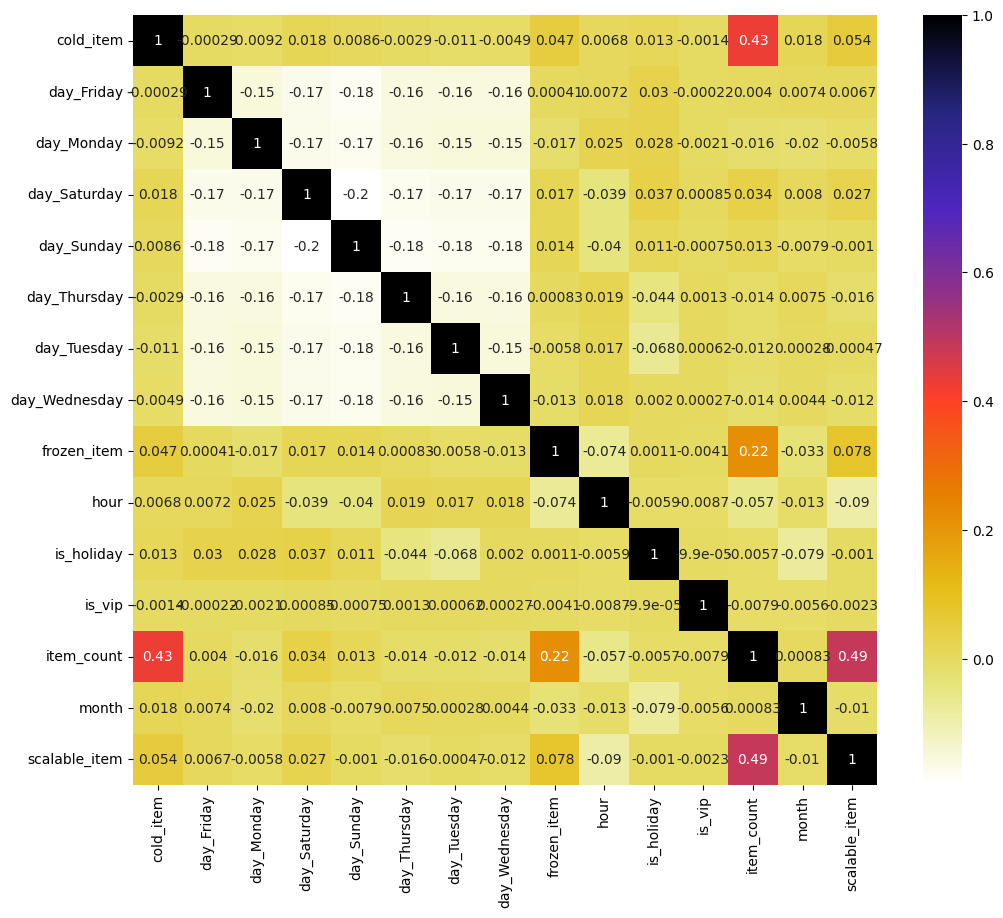

In [7]:
# Correlation matrix map
plt.figure(figsize=(12,10))
cor = X_train.corr() #method='pearson' or 'spearman'
sns.heatmap(cor,annot=True,cmap= plt.cm.CMRmap_r)
plt.show()

In [8]:
def correlation(dataset,threshold):
    col_corr = set() # set all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if(corr_matrix.iloc[i,j])> threshold:
                colname= corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [9]:
# corr_features = correlation(X_train,0.7)
# len(set(corr_features))
# corr_features

In [10]:
# Define hyperparameter grid
parameters = {
    'objective': ['reg:squarederror'],
    'booster': ['gbtree'],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [7, 10, 15, 20, 25, 30],
    'min_child_weight': [10, 15, 20, 25],
    'colsample_bytree': [0.8, 0.9, 1],
    'n_estimators': [100, 200, 300, 400, 500, 600],
    "reg_alpha": [0.5, 0.2, 1],
    "reg_lambda": [2, 3, 5],
    "gamma": [1, 2, 3]
}

# Initialize XGBoost model
xgb_model = XGBRegressor(random_state=42)

In [11]:
# Initialize RandomizedSearchCV
grid_xgb = RandomizedSearchCV(xgb_model, parameters, cv=5, n_iter=10, scoring='neg_mean_absolute_error', verbose=3, n_jobs= -1)

# Fit RandomizedSearchCV
grid_xgb.fit(X_train, y_train)

# Extract best estimator
best_xgb_model = grid_xgb.best_estimator_

# Train final XGBoost model with best hyperparameters
best_xgb_model.fit(X_train, y_train, eval_metric=["rmse"], eval_set=[(X_train, y_train), (X_test, y_test)], verbose=1)
''' If validation set is used, replace X_test and y_test with X_val and y_val'''

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# y_pred = np.expm1(y_pred_logged)
# y_test = np.expm1(y_test_logged)

# Evaluate predictions
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rsquared = r2_score(y_test, y_pred)

print("R-squared: %.4f" % rsquared)
print("RMSE: %.4f" % rmse)
print("MAE : %.4f" % mae)

p_accuracy = [(1 - np.abs(pred - actual) / actual) * 100 for pred, actual in zip(y_pred, y_test)]

# Print P_accuracy
print("P_accuracy: Mean: %.2f%%, Min: %.2f%%, Max: %.2f%%" % (np.mean(p_accuracy), np.min(p_accuracy), np.max(p_accuracy)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, gamma=2, learning_rate=0.2, max_depth=15, min_child_weight=25, n_estimators=200, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=5;, score=-1.536 total time=  11.2s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, gamma=2, learning_rate=0.2, max_depth=15, min_child_weight=25, n_estimators=200, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=5;, score=-1.537 total time=  11.9s
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, gamma=2, learning_rate=0.2, max_depth=15, min_child_weight=25, n_estimators=200, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=5;, score=-1.537 total time=  11.9s
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, gamma=3, learning_rate=0.2, max_depth=10, min_child_weight=10, n_estimators=200, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=2;, score=-1.531 total time=   8.8s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:2.00093	validation_1-rmse:2.00609
[5]	validation_0-rmse:1.97892	validation_1-rmse:1.98389
[6]	validation_0-rmse:1.96450	validation_1-rmse:1.96935
[7]	validation_0-rmse:1.95503	validation_1-rmse:1.95976
[8]	validation_0-rmse:1.94880	validation_1-rmse:1.95343
[9]	validation_0-rmse:1.94460	validation_1-rmse:1.94920
[10]	validation_0-rmse:1.94178	validation_1-rmse:1.94642
[11]	validation_0-rmse:1.93985	validation_1-rmse:1.94453
[12]	validation_0-rmse:1.93848	validation_1-rmse:1.94327
[13]	validation_0-rmse:1.93748	validation_1-rmse:1.94237
[14]	validation_0-rmse:1.93662	validation_1-rmse:1.94158
[15]	validation_0-rmse:1.93604	validation_1-rmse:1.94111
[16]	validation_0-rmse:1.93545	validation_1-rmse:1.94063
[17]	validation_0-rmse:1.93509	validation_1-rmse:1.94031
[18]	validation_0-rmse:1.93472	validation_1-rmse:1.94005
[19]	validation_0-rmse:1.93437	validation_1-rmse:1.93982
[20]	validation_0-rmse:1.93405	validation_1-rmse:1.93963
[21]	validation_0-rmse:1.93367	valida

In [12]:
# print best hyperparameters
print(grid_xgb.best_params_)

{'reg_lambda': 5, 'reg_alpha': 0.2, 'objective': 'reg:squarederror', 'n_estimators': 500, 'min_child_weight': 25, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 3, 'colsample_bytree': 1, 'booster': 'gbtree'}


In [13]:
min_index = np.argmin(p_accuracy)
max_index = np.argmax(p_accuracy)
min_p_accuracy = p_accuracy[min_index]
corresponding_pred = y_pred[min_index]
corresponding_actual = y_test.iloc[min_index]

print("Minimum P_accuracy: %.2f%%" % min_p_accuracy)
print("Corresponding Prediction:", corresponding_pred)
print("Corresponding Actual Value:", corresponding_actual)

Minimum P_accuracy: -56.56%
Corresponding Prediction: 10.818423
Corresponding Actual Value: 4.216666666666667


In [14]:
less_than_zero = [p_acc for p_acc in p_accuracy if p_acc < 0]
more_than_zero = [p_acc for p_acc in p_accuracy if p_acc > 0]

count_less_than_zero = len(less_than_zero)
count_more_than_zero = len(more_than_zero)

print(f"The total {count_more_than_zero} values are greater than 0%.")
print(f"The total {count_less_than_zero} values are less than 0%.")

The total 267964 values are greater than 0%.
The total 3009 values are less than 0%.


In [15]:
# Identify the indices of the 10 lowest P_accuracy values
worst_indices = np.argsort(p_accuracy)[:10]
max_indices = np.argsort(p_accuracy)[-10:]
# Extract the worst 10 features, predicted values, and actual values corresponding to the minimum P_accuracy
worst_features = X_test.iloc[worst_indices]
max_features = X_test.iloc[max_indices]
max_predicted_values = pd.Series(y_pred[max_indices], name='Predicted')
worst_predicted_values = pd.Series(y_pred[worst_indices], name='Predicted')
worst_actual_values = y_test.iloc[worst_indices].reset_index(drop=True)
max_actual_values = y_test.iloc[max_indices].reset_index(drop=True)

max_table = pd.concat([max_features.reset_index(drop=True), max_predicted_values, max_actual_values], axis=1)
# Create a DataFrame to display the features, predicted values, and actual values in a table
worst_table = pd.concat([worst_features.reset_index(drop=True), worst_predicted_values, worst_actual_values], axis=1)

# Print the table of the worst 10 features, predicted values, and actual values corresponding to the minimum P_accuracy
print("Worst 10 Features, Predicted Values, and Actual Values corresponding to Minimum P_accuracy:")
print(worst_table.to_string(index=False))
print('----------------------------------------------------------------------------------------')
print("Max 10 Features, Predicted Values, and Actual Values corresponding to Maximum P_accuracy:")
print(max_table.to_string(index=False))

Worst 10 Features, Predicted Values, and Actual Values corresponding to Minimum P_accuracy:
 cold_item  day_Friday  day_Monday  day_Saturday  day_Sunday  day_Thursday  day_Tuesday  day_Wednesday  frozen_item  hour  is_holiday  is_vip  item_count  month  scalable_item  Predicted  collection_duration
         0       False        True         False       False         False        False          False            0     9           0       0        19.0     11              9  10.818423             4.216667
         2       False       False         False        True         False        False          False            0    20           0       0        19.0      7              9  10.922776             4.300000
         0       False       False          True       False         False        False          False            0    11           0       0         2.0      8              0   3.808596             1.500000
         0       False       False         False        True         False  

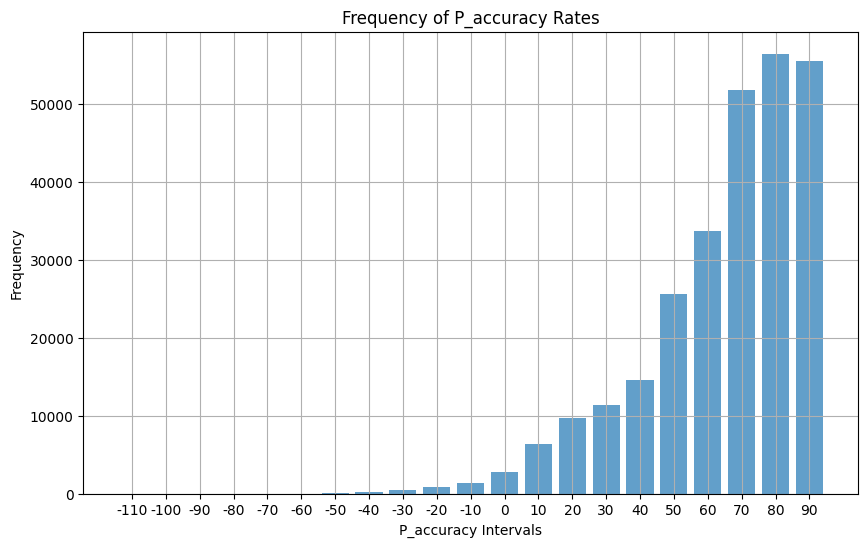

----------------------------------------------------------------------------------------
Interval: [-110%, -100%] - Frequency: 0
Interval: [-100%, -90%] - Frequency: 0
Interval: [-90%, -80%] - Frequency: 0
Interval: [-80%, -70%] - Frequency: 0
Interval: [-70%, -60%] - Frequency: 0
Interval: [-60%, -50%] - Frequency: 4
Interval: [-50%, -40%] - Frequency: 76
Interval: [-40%, -30%] - Frequency: 249
Interval: [-30%, -20%] - Frequency: 491
Interval: [-20%, -10%] - Frequency: 822
Interval: [-10%, 0%] - Frequency: 1367
Interval: [0%, 10%] - Frequency: 2818
Interval: [10%, 20%] - Frequency: 6371
Interval: [20%, 30%] - Frequency: 9698
Interval: [30%, 40%] - Frequency: 11401
Interval: [40%, 50%] - Frequency: 14549
Interval: [50%, 60%] - Frequency: 25585
Interval: [60%, 70%] - Frequency: 33732
Interval: [70%, 80%] - Frequency: 51807
Interval: [80%, 90%] - Frequency: 56479
Interval: [90%, 100%] - Frequency: 55524


In [16]:
#Scatter plots showing the frequency similarity from –100 to 100 by 10 percent intervals

# Define the intervals
intervals = np.arange(-110, 110, 10)

# Count the frequency of p_accuracy within each interval
frequency = []
for i in range(len(intervals)-1):
    count = ((p_accuracy >= intervals[i]) & (p_accuracy < intervals[i+1])).sum()
    frequency.append(count)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(intervals)-1), frequency, align='center', alpha=0.7)
plt.xticks(np.arange(len(intervals)-1), intervals[:-1])
plt.xlabel('P_accuracy Intervals')
plt.ylabel('Frequency')
plt.title('Frequency of P_accuracy Rates')
plt.grid(True)
plt.show()
print("----------------------------------------------------------------------------------------")
for i in range(len(intervals)-1):
    print("Interval: [%d%%, %d%%] - Frequency: %d" % (intervals[i], intervals[i+1], frequency[i]))

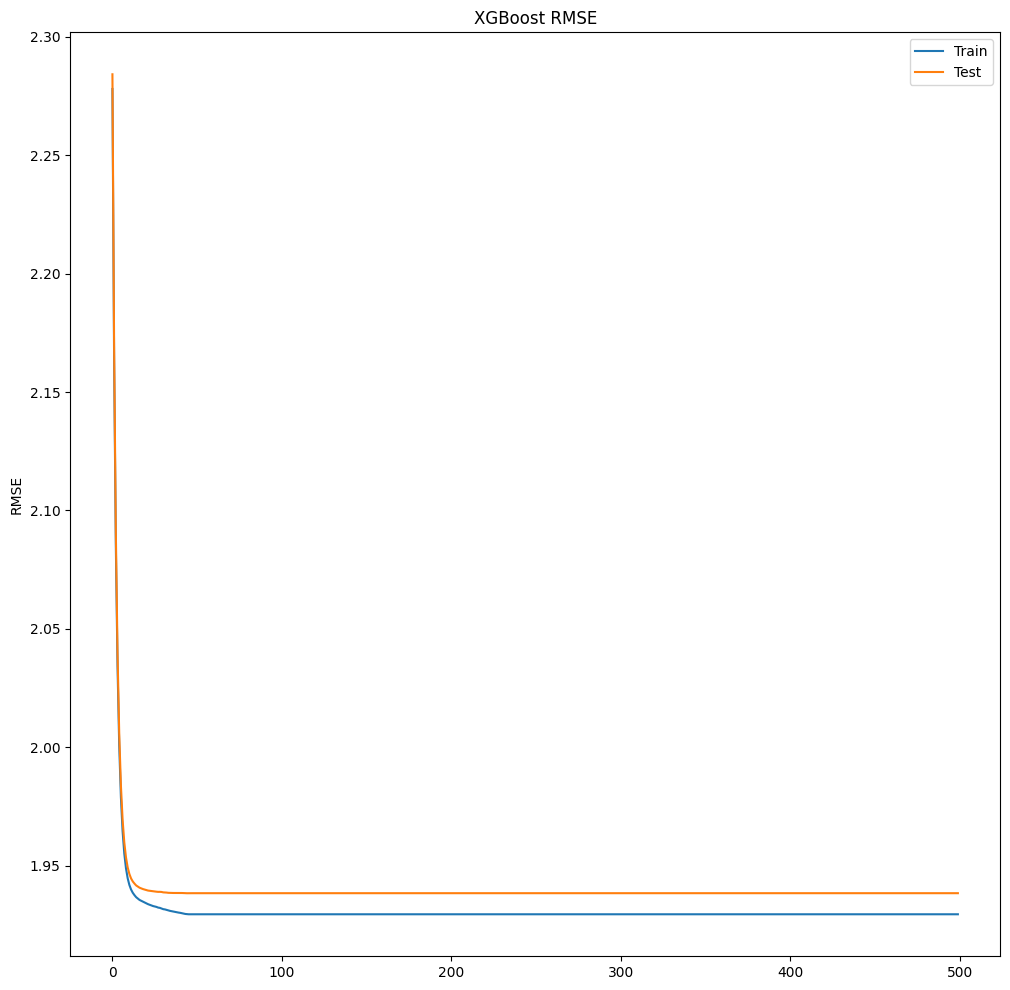

In [17]:
# Retrieve performance metrics
results = best_xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot RMSE
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()

plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [18]:
#print 

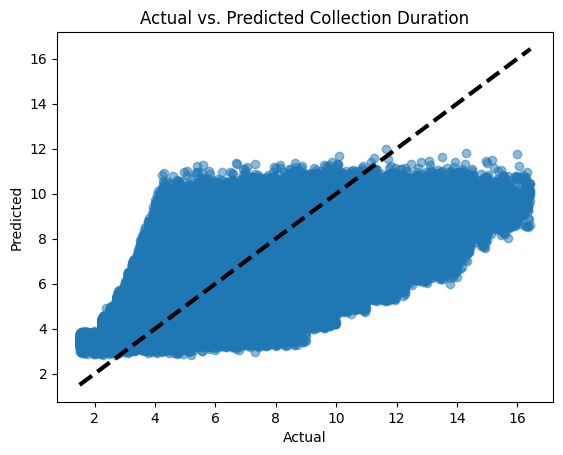

In [19]:
# Plot predicted vs. actual values
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, label='Ideal Prediction')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted Collection Duration")
plt.show()

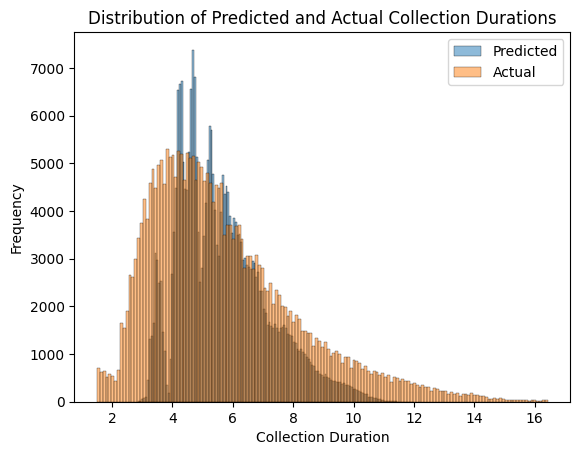

In [23]:
# Plot the distribution of predicted values

sns.histplot(y_pred, alpha=0.5, label='Predicted')
sns.histplot(y_test, alpha=0.5, label='Actual')

plt.xlabel('Collection Duration')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted and Actual Collection Durations')
plt.legend()
plt.show()

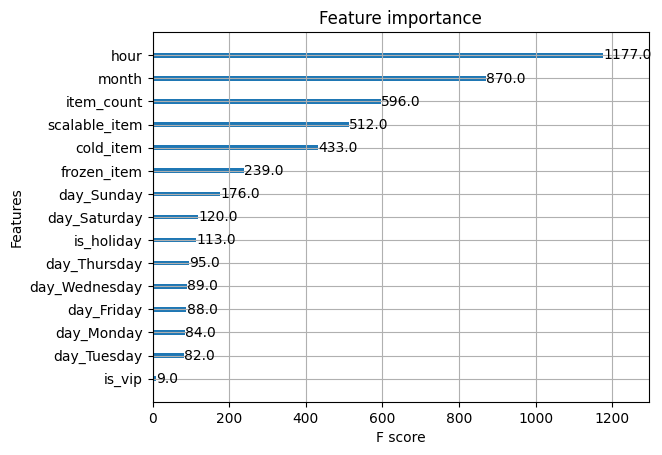

In [21]:
# Plot the first 25 most important features
plot_importance(best_xgb_model, max_num_features=25)
plt.show()